<a href="https://colab.research.google.com/github/AbouCamara/IA-FORCE-N/blob/main/Syst%C3%A8me_de_Classification_d'images_de_cultures_agricoles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Proposition de Monsieur CAMARA

In [ ]:
import kagglehub
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import defaultdict
from tqdm import tqdm
from google.colab import drive
from PIL import Image
import random
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Monter Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Définir le chemin du fichier zip et du dossier d'extraction
zip_path = '/content/drive/MyDrive/Data/extracted_files/archive.zip'  # Mettre à jour si nécessaire
extract_folder = '/content/drive/MyDrive/Data/Agricultural-corps/extracted/'  # Dossier où extraire

# Vérifier si le fichier zip existe et est un fichier zip valide
if os.path.exists(zip_path) and zipfile.is_zipfile(zip_path):
    # Créer le dossier d'extraction si nécessaire
    os.makedirs(extract_folder, exist_ok=True)

    # Dézipper le fichier
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
    print(f"Fichiers extraits dans {extract_folder}")
else:
    print(f"Le fichier à {zip_path} n'existe pas ou n'est pas un fichier zip valide. Vérifiez le chemin et l'intégrité du fichier.")

Le fichier à /content/drive/MyDrive/Data/extracted_files/archive.zip n'existe pas ou n'est pas un fichier zip valide. Vérifiez le chemin et l'intégrité du fichier.


In [ ]:
# Chemin d'accès aux images
# Chemin vers votre dossier dans Google Drive
drive_path = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops'
## drive_path ='/content/drive/MyDrive/Colab Notebooks/Agricultural-crops'
# Vérifier le contenu du dossier
!ls "{drive_path}"

 almond      Coffee-plant	 image17.jpeg   Lemon		       soyabean
 augmented   cotton		 image18.jpeg   maize		       sugarcane
 banana      Cucumber		 image20.jpeg   mustard-oil	       sunflower
 cardamom    flipped		 image21.jpeg   Olive-tree	       tea
 Cherry     'Fox_nut(Makhana)'	 image22.jpeg   papaya		       Tobacco-plant
 chilli      gram		 image24.jpeg  'Pearl_millet(bajra)'   tomato
 clove	     image15.jpeg	 jowar	        pineapple	      'vigna-radiati(Mung)'
 coconut     image16.jpeg	 jute	        rice		       wheat


In [ ]:
# Fonction de chargement des images

def load_images_from_drive(folder_path, img_size=(128, 128), max_images=None):
    """
    Charge les images depuis Google Drive
    Args:
        folder_path (str): Chemin relatif dans Google Drive
        img_size (tuple): Taille de redimensionnement
        max_images (int): Nombre max d'images à charger (None = toutes)
    Returns:
        tuple: (images, labels, class_names)
    """
    full_path = os.path.join(drive_path, folder_path)
    class_names = sorted([d for d in os.listdir(full_path) if os.path.isdir(os.path.join(full_path, d))])

    images = []
    labels = []

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(full_path, class_name)
        files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if max_images:
            files = files[:max_images]

        print(f"Chargement {len(files)} images de la classe {class_name}...")

        for file in tqdm(files):
            try:
                img_path = os.path.join(class_dir, file)
                img = cv2.imread(img_path)

                if img is None:
                    continue

                # Conversion BGR vers RGB + redimensionnement
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)
                img = img.astype(np.float32) / 255.0  # Normalisation

                images.append(img)
                labels.append(label)

            except Exception as e:
                print(f"Erreur avec {file}: {str(e)}")

    return np.array(images), np.array(labels), class_names

# **Augmentation de données**

In [ ]:
# Dossier contenant les images à augmenter
input_folder = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops/'

# Dossier de sortie pour les images augmentées
output_folder = '/content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/'

# Crée le dossier de sortie s'il n'existe pas
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Parcours les fichiers dans le dossier d'entrée
for file_name in os.listdir(input_folder):
    file_path = os.path.join(input_folder, file_name)

    # Vérifie si c'est un fichier image
    if os.path.isfile(file_path) and file_name.endswith(('jpg', 'jpeg', 'png')):
        try:
            # Ouvre l'image
            image = Image.open(file_path)

            # Applique les augmentations : retournement horizontal et vertical
            if random.choice([True, False]):  # 50% de chance pour chaque transformation
                image = image.transpose(Image.FLIP_LEFT_RIGHT)  # Retournement horizontal
            if random.choice([True, False]):
                image = image.transpose(Image.FLIP_TOP_BOTTOM)  # Retournement vertical

            # Sauvegarde l'image augmentée
            augmented_image_path = os.path.join(output_folder, file_name)
            image.save(augmented_image_path)

            print(f"Image augmentée sauvegardée : {augmented_image_path}")

        except Exception as e:
            print(f"Erreur lors de l'ouverture ou de l'augmentation de l'image {file_name}: {e}")


Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image17.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image18.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image20.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image24.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image21.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image16.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image22.jpeg
Image augmentée sauvegardée : /content/drive/MyDrive/Data/extracted_files/Agricultural-crops/augmented/image15.jpeg


In [ ]:
# Utilisation

# Exemple de chemin (à adapter)
dataset_folder = "/content/drive/MyDrive/Data/extracted_files/Agricultural-crops"  # Doit contenir des sous-dossiers par classe
## dataset_folder ='/content/drive/MyDrive/Colab Notebooks/Agricultural-crops'
# Chargement
images, labels, classes = load_images_from_drive(
    folder_path=dataset_folder,
    img_size=(128, 128),
    max_images=1000  # Limiter à 1000 images par classe
)

# Vérification
print(f"\nDimensions des données : {images.shape}")
print(f"Exemple de label : {labels[0]} ({classes[labels[0]]})")

# Visualisation
plt.figure(figsize=(15, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(classes[labels[i]])
    plt.axis('off')
plt.show()

# Définition du modèle CNN : Convolutional Neural Network
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Définir le modèle
# (Votre définition de modèle existante)

# Diviser les données
total_size = len(images)
train_size = int(0.8 * total_size)
X_train, X_test = images[:train_size], images[train_size:]
y_train, y_test = labels[:train_size], labels[train_size:]

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

Chargement 32 images de la classe Cherry...


100%|██████████| 32/32 [00:10<00:00,  3.06it/s]


Chargement 29 images de la classe Coffee-plant...


100%|██████████| 29/29 [00:10<00:00,  2.67it/s]


Chargement 31 images de la classe Cucumber...


100%|██████████| 31/31 [00:12<00:00,  2.46it/s]


Chargement 23 images de la classe Fox_nut(Makhana)...


100%|██████████| 23/23 [00:07<00:00,  3.22it/s]


Chargement 28 images de la classe Lemon...


100%|██████████| 28/28 [00:08<00:00,  3.33it/s]


Chargement 30 images de la classe Olive-tree...


100%|██████████| 30/30 [00:14<00:00,  2.08it/s]


Chargement 39 images de la classe Pearl_millet(bajra)...


100%|██████████| 39/39 [00:15<00:00,  2.53it/s]


Chargement 33 images de la classe Tobacco-plant...


100%|██████████| 33/33 [00:10<00:00,  3.23it/s]


Chargement 21 images de la classe almond...


100%|██████████| 21/21 [00:09<00:00,  2.26it/s]


Chargement 8 images de la classe augmented...


100%|██████████| 8/8 [00:00<00:00, 164.36it/s]


Chargement 31 images de la classe banana...


100%|██████████| 31/31 [00:14<00:00,  2.16it/s]


Chargement 22 images de la classe cardamom...


 45%|████▌     | 10/22 [00:03<00:03,  3.47it/s]

# **Analyse exploratoire des données**

Nombre total de classes: 32


<ipython-input-19-110319638b3c>:38: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


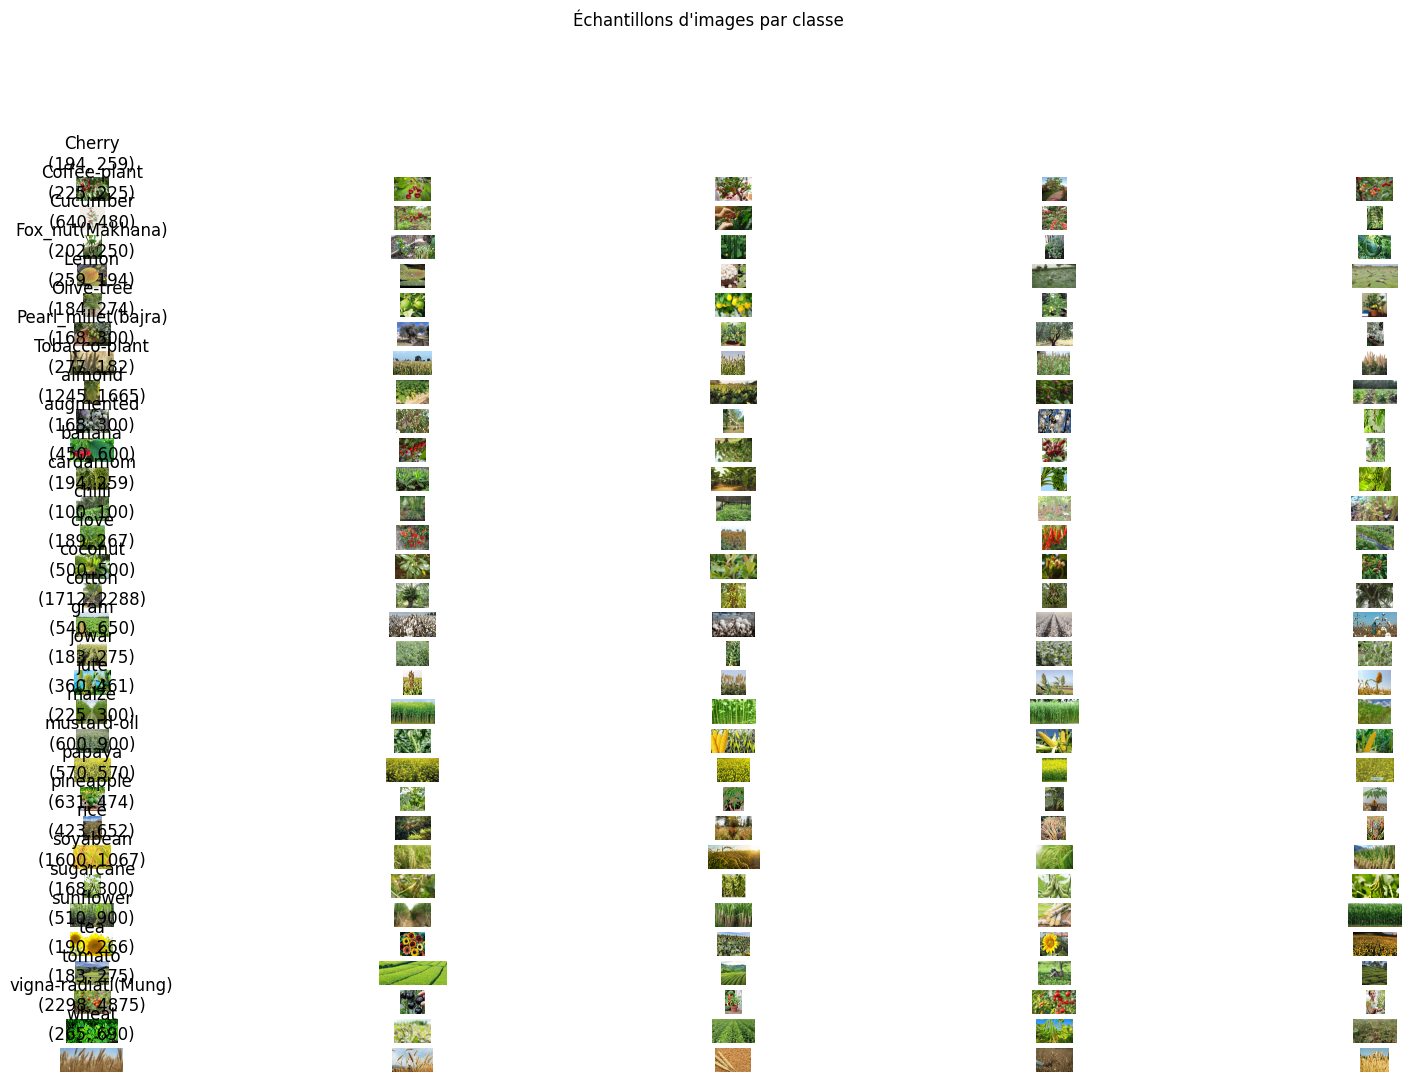

<ipython-input-19-110319638b3c>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")


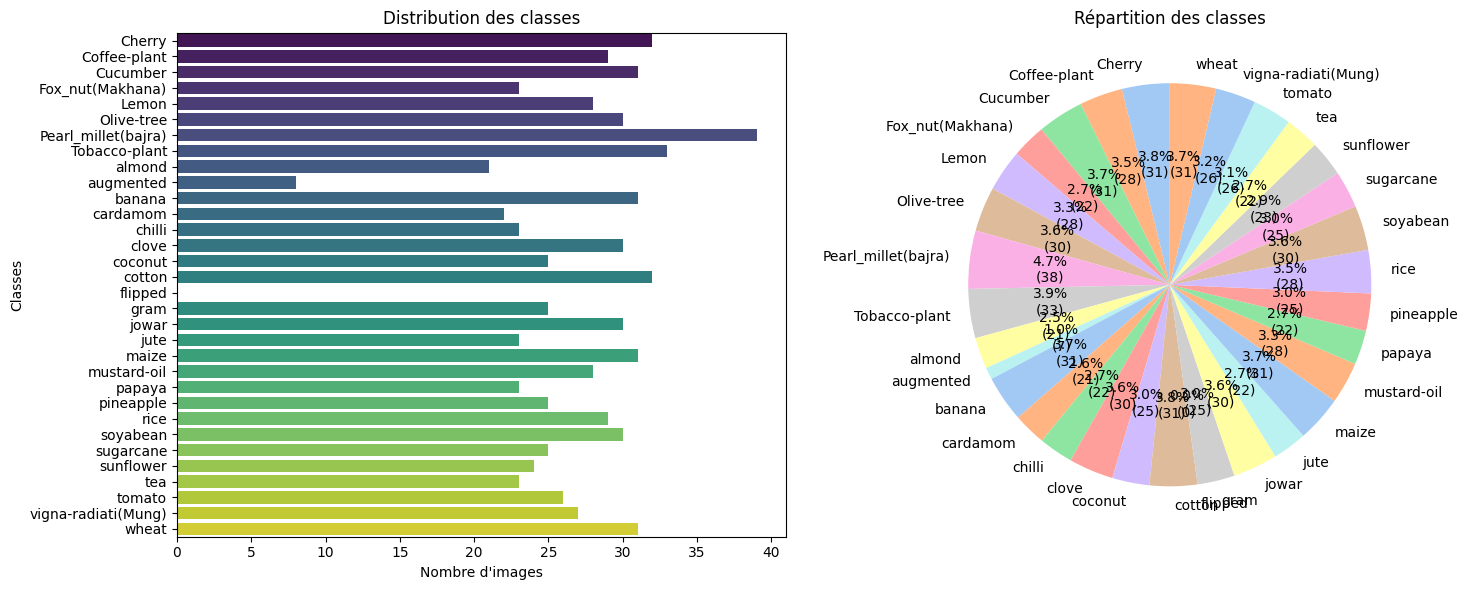


Statistiques détaillées:
Nombre total d'images: 837
Nombre moyen d'images par classe: 26.2
Écart-type: 7.0
Classe la plus fréquente: Pearl_millet(bajra) (39 images)
Classe la moins fréquente: flipped (0 images)

⚠️ Alerte: Déséquilibre important détecté !
Ratio min/max: 0.00
Solutions possibles:
- Data Augmentation pour les classes minoritaires
- Rééchantillonnage (oversampling/undersampling)
- Utilisation de class weights pendant l'entraînement


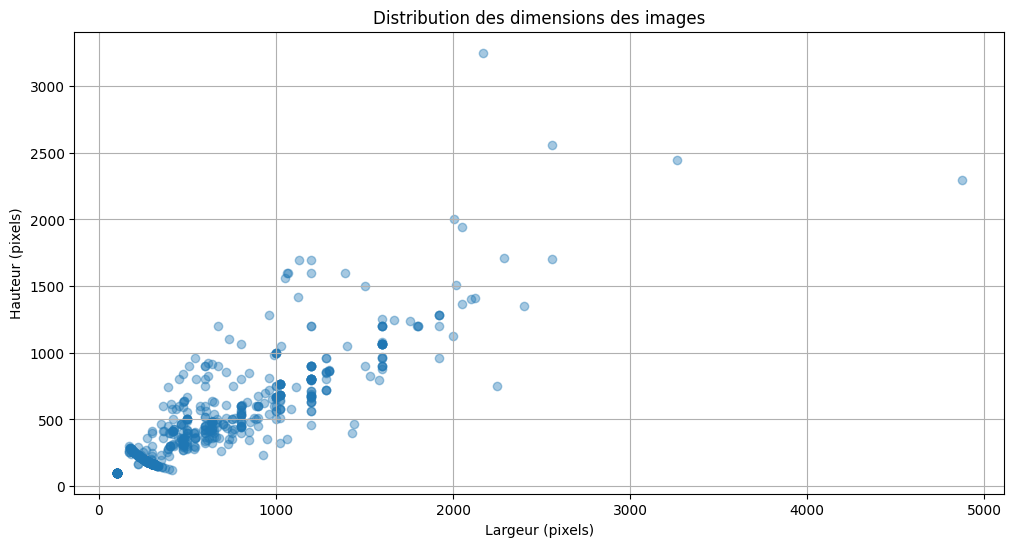

In [ ]:
# Configuration
# Chemin vers vos données
DATASET_PATH = "/content/drive/MyDrive/Data/extracted_files/Agricultural-crops"

# Nombre d'échantillons à visualiser par classe
SAMPLE_PER_CLASS = 5

# 1. Exploration initiale du dataset
class_counts = defaultdict(int)
class_names = sorted([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])

print(f"Nombre total de classes: {len(class_names)}")

# 2. Visualisation d'échantillons d'images
plt.figure(figsize=(20, 12))
plot_index = 1

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images)

    # Affichage d'échantillons d'images
    for img_idx in range(SAMPLE_PER_CLASS):
        if img_idx >= len(images):
            break

        img_path = os.path.join(class_dir, images[img_idx])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        plt.subplot(len(class_names), SAMPLE_PER_CLASS, plot_index)
        plt.imshow(img)
        plt.title(f"{class_name}\n{img.shape[:2]}" if img_idx == 0 else "")
        plt.axis('off')
        plot_index += 1

plt.suptitle("Échantillons d'images par classe", y=1.02)
plt.tight_layout()
plt.show()

# 3. Analyse de la distribution des classes
plt.figure(figsize=(15, 6))

# Diagramme en barres
plt.subplot(1, 2, 1)
sns.barplot(x=list(class_counts.values()), y=list(class_counts.keys()), palette="viridis")
plt.title("Distribution des classes")
plt.xlabel("Nombre d'images")
plt.ylabel("Classes")

# Diagramme circulaire
plt.subplot(1, 2, 2)
plt.pie(class_counts.values(),
        labels=class_counts.keys(),
        autopct=lambda p: f'{p:.1f}%\n({int(p*sum(class_counts.values())/100)})',
        startangle=90,
        colors=sns.color_palette("pastel"))
plt.title("Répartition des classes")
plt.tight_layout()
plt.show()

# 4. Statistiques détaillées
total_images = sum(class_counts.values())
print("\nStatistiques détaillées:")
print(f"Nombre total d'images: {total_images}")
print(f"Nombre moyen d'images par classe: {np.mean(list(class_counts.values())):.1f}")
print(f"Écart-type: {np.std(list(class_counts.values())):.1f}")
print(f"Classe la plus fréquente: {max(class_counts, key=class_counts.get)} ({max(class_counts.values())} images)")
print(f"Classe la moins fréquente: {min(class_counts, key=class_counts.get)} ({min(class_counts.values())} images)")

# 5. Détection des déséquilibres

# Ratio acceptable entre plus petite et plus grande classe
balance_threshold = 0.3
max_count = max(class_counts.values())
min_count = min(class_counts.values())

if min_count/max_count < balance_threshold:
    print("\n⚠️ Alerte: Déséquilibre important détecté !")
    print(f"Ratio min/max: {min_count/max_count:.2f}")
    print("Solutions possibles:")
    print("- Data Augmentation pour les classes minoritaires")
    print("- Rééchantillonnage (oversampling/undersampling)")
    print("- Utilisation de class weights pendant l'entraînement")
else:
    print("\n✅ Distribution relativement équilibrée")

# 6. Visualisation avancée des dimensions d'images
sizes = []
for class_name in class_names:
    class_dir = os.path.join(DATASET_PATH, class_name)
    for img_file in os.listdir(class_dir)[:100]:  # Échantillonner pour gagner du temps
        img = cv2.imread(os.path.join(class_dir, img_file))
        if img is not None:
            sizes.append(img.shape[:2])

sizes = np.array(sizes)
plt.figure(figsize=(12, 6))
plt.scatter(sizes[:, 1], sizes[:, 0], alpha=0.4)  # width vs height
plt.title("Distribution des dimensions des images")
plt.xlabel("Largeur (pixels)")
plt.ylabel("Hauteur (pixels)")
plt.grid(True)
plt.show()

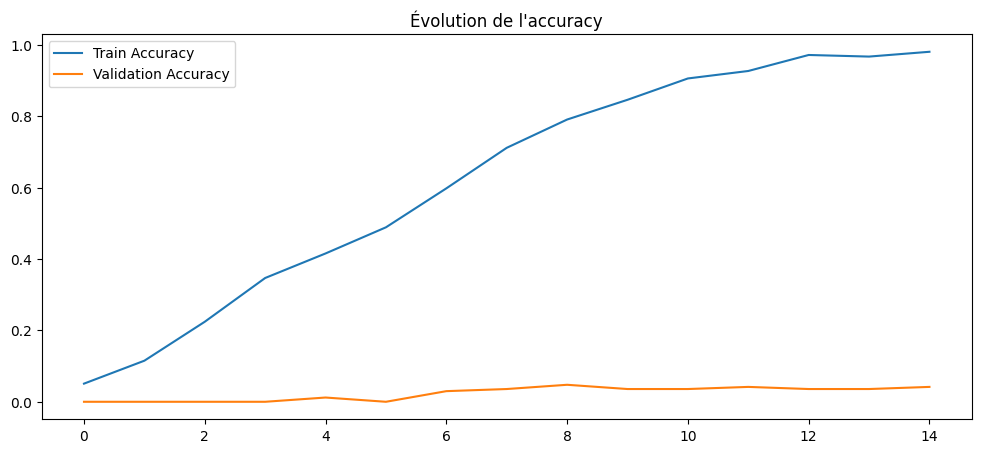

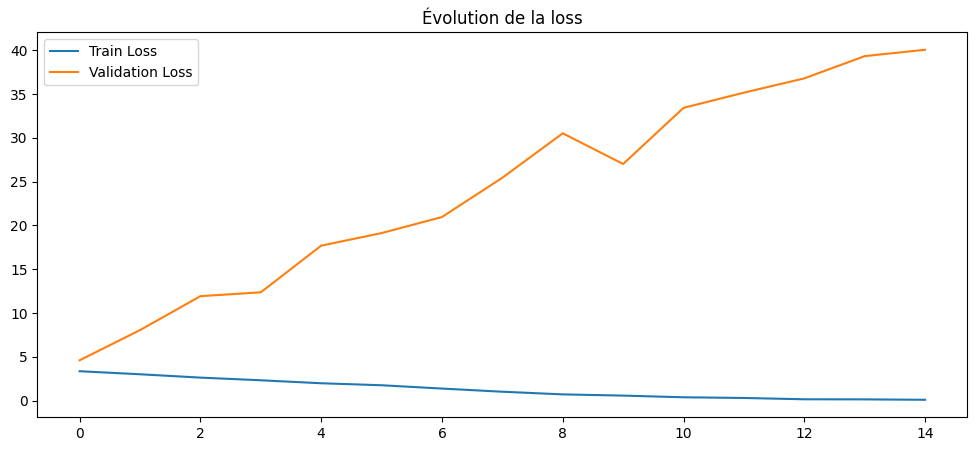

In [ ]:
# Affichage des courbes d'apprentissage
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Évolution de l'accuracy")
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Évolution de la loss")
plt.show()